In [692]:
import numpy as np
from numba import jit

@jit(nopython=True)
def fermi(energy, beta):
    return np.exp(-energy * beta) / (1. + np.exp(-energy * beta))

@jit(nopython=True)
def get_fft(N):
    W = np.zeros((N ** 2, N ** 2), dtype=np.complex128)
    for kx in range(N):
        for ky in range(N):
            for x in range(N):
                for y in range(N):
                    W[x * N + y, kx * N + ky] = np.exp(2.0j * np.pi / N * kx * x + 2.0j * np.pi / N * ky * y)
    return W

L = 32
K = np.zeros((L ** 2, L ** 2), dtype=np.float64)
tp = 0.0
for x in range(L):
    for y in range(L):
        idx = y * L + x
        idx_up = ((y + 1) % L) * L + x
        idx_right = y * L + (x + 1) % L
        
        K[idx, idx_up] = -1.
        K[idx, idx_right] = -1.
        
        idx_up = ((y + 1) % L) * L + (x + 1) % L
        idx_right = ((y - 1) % L) * L + (x + 1) % L
        
        K[idx, idx_up] = tp
        K[idx, idx_right] = tp
        
        
K0 = K + K.T
print(np.linalg.eigh(K0))
K0 = K0 - np.diag(np.diag(K0) * 0. + 0.001)
Ls = L

n_bands = 1
fft = get_fft(Ls)

### doing the FFT of K0 ###
K0_fft = fft.conj().T.dot(K0).dot(fft)

K0_check = K0_fft.copy()
for i in range(K0_check.shape[0] // n_bands):
    K0_check[i * n_bands:i * n_bands + n_bands,i * n_bands:i * n_bands + n_bands] = 0.0
#assert np.isclose(np.sum(np.abs(K0_check)), 0.0)

A = np.zeros((L, L, n_bands, n_bands), dtype=np.complex128)
energies = np.zeros((L, L, n_bands), dtype=np.complex128)
for i in range(K0_check.shape[0] // n_bands):
    kx, ky = i % L, i // L
    A[kx, ky, ...] = np.linalg.eigh(K0_fft[i * n_bands:i * n_bands + n_bands,i * n_bands:i * n_bands + n_bands])[1]
    energies[kx, ky, ...] = np.linalg.eigh(K0_fft[i * n_bands:i * n_bands + n_bands,i * n_bands:i * n_bands + n_bands])[0]

    
@jit(nopython=True)
def get_susc_zero(Ls, n_bands, A, A_plus_q, energies, energies_plus_q, omega, temp):
    chi = np.zeros((n_bands, n_bands, n_bands, n_bands), dtype=np.complex128)
    for kx in range(Ls):
        for ky in range(Ls):
            for alpha in range(n_bands):
                for beta in range(n_bands):
                    for p in range(n_bands):
                        for q in range(n_bands):
                            for s in range(n_bands):
                                for t in range(n_bands):
                                    chi[p, q, s, t] -= A[kx, ky, s, alpha] * \
                                               np.conj(A[kx, ky, p, alpha]) * \
                                                       A_plus_q[kx, ky, q, beta] * \
                                               np.conj(A_plus_q[kx, ky, t, beta]) / \
                                                (omega + energies_plus_q[kx, ky, beta] - energies[kx, ky, alpha] + 1e-10j) * \
                                                (fermi(energies_plus_q[kx, ky, beta], temp) - fermi(energies[kx, ky, alpha], temp))
                 
    return chi / n_bands / Ls ** 2 ## FIXME: factor?

omega = 0.
beta = 0.01
susc_0 = np.zeros((L, L, n_bands, n_bands, n_bands, n_bands), dtype=np.complex128)
for qx in range(Ls):
    for qy in range(Ls):
        A_plus_q = np.roll(A, shift = qx, axis=0)
        A_plus_q = np.roll(A_plus_q, shift = qy, axis=1)
    
        energies_plus_q = np.roll(energies, shift = qx, axis=0)
        energies_plus_q = np.roll(energies_plus_q, shift = qy, axis=1)
        susc_0[qx, qy, ...] = get_susc_zero(Ls, n_bands, A, A_plus_q, energies, energies_plus_q, omega, beta)

green = np.zeros((Ls, Ls, n_bands, n_bands), dtype=np.complex128)
for kx in range(Ls):
    for ky in range(Ls):
        for a in range(n_bands):
            for b in range(n_bands):
                for band in range(n_bands):
                    green[kx, ky, a, b] =+ A[kx, ky, a, band] * np.conj(A[kx, ky, b, band]) / (-energies[kx, ky, band])


(array([-4.        , -3.96157056, -3.96157056, ...,  3.96157056,
        3.96157056,  4.        ]), array([[-3.12500000e-02, -7.54823842e-03,  6.20425185e-02, ...,
        -3.09713340e-16, -6.58544457e-21,  3.12500000e-02],
       [-3.12500000e-02, -2.16033450e-03,  6.20931359e-02, ...,
        -2.34746862e-03, -3.09825850e-03, -3.12500000e-02],
       [-3.12500000e-02,  4.13224518e-03,  6.10672887e-02, ...,
         4.93939878e-03,  5.00423923e-03,  3.12500000e-02],
       ...,
       [-3.12500000e-02, -1.55263591e-02,  5.51615853e-02, ...,
        -1.28962639e-02, -1.58466894e-02,  3.12500000e-02],
       [-3.12500000e-02, -1.39175995e-02,  5.82664146e-02, ...,
         1.17690336e-02,  1.00447950e-02, -3.12500000e-02],
       [-3.12500000e-02, -1.09174863e-02,  6.04228327e-02, ...,
        -1.01682624e-02, -4.96041699e-03,  3.12500000e-02]]))


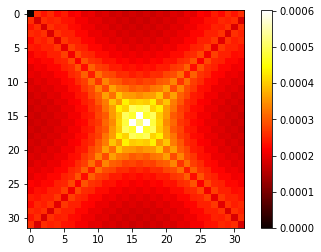

In [693]:
import matplotlib.pyplot as plt
plt.imshow(susc_uniform, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

In [719]:
def get_U(U):
    U_total = np.zeros((2, 2, 2, 2), dtype=np.float64)
    U_total[0, 0, 1, 1] = -U
    U_total[0, 1, 0, 1] = +U
    U_total[1, 0, 1, 0] = +U
    U_total[1, 1, 0, 0] = -U
    
    return U_total

U_total = get_U(10)
U_s = U_total[0, 0, 0, 0] - U_total[0, 0, 1, 1]
U_c = -U_total[0, 0, 0, 0] - U_total[0, 0, 1, 1]
print(U_s, U_c)
chi_s = susc_0 / (1 - U_s * susc_0)
chi_c = susc_0 / (1 + U_c * susc_0)
print(np.sum(np.abs(susc_0 - susc_0.T.conj())))

10.0 10.0
69.11235124005208


In [710]:
Gsinglet = 3. / 2. * U_s * chi_s * U_s + U_s / 2. + U_c / 2. - 0.5 * U_c * chi_c * U_c
Gsinglet.shape

op = np.zeros((Ls, Ls, Ls, Ls, n_bands, n_bands, n_bands, n_bands), dtype=np.complex128)
for kx in range(Ls):
    for ky in range(Ls):
        for qx in range(Ls):
            for qy in range(Ls):
                for abar in range(n_bands):
                    for bbar in range(n_bands):
                        for cbar in range(n_bands):
                            for dbar in range(n_bands):
                                for a in range(n_bands):
                                    for b in range(n_bands):
                                        op[kx, ky, qx, qy, abar, bbar, cbar, dbar] -= 1. / Ls ** 2 / beta * Gsinglet[(kx - qx) % Ls, (ky - qy) % Ls, a, abar, bbar, b] * green[qx, qy, a, cbar] * green[-qx % Ls, -qy % Ls, b, dbar]

In [711]:
op.shape

(32, 32, 32, 32, 1, 1, 1, 1)

In [712]:
op = op.transpose((0, 1, 4, 5, 2, 3, 6, 7)).reshape((Ls, Ls, n_bands, n_bands, -1))

In [713]:
op.shape

(32, 32, 1, 1, 1024)

In [714]:
op = op.transpose((4, 0, 1, 2, 3)).reshape((Ls ** 2 * n_bands ** 2, -1))

In [722]:
print(np.sum(np.abs(op - op.T)), np.sum(np.abs(op)))

111383.56690585878 59282.46562684646


In [724]:
from scipy.sparse.linalg import eigsh
E, eig = eigs(op, k=2, which='LR')
print(E)

[0.02816346-1.05463814e-16j 0.01979412+5.29718523e-16j]


In [702]:
eig[:, 0][np.where(np.abs(eig[:, 0]) > 3e-1)[0]]

array([], dtype=complex128)

In [703]:
print(np.where(np.abs(eig[:, 0]) > 3e-1)[0] // Ls)
print(np.where(np.abs(eig[:, 0]) > 3e-1)[0] % Ls)

[]
[]


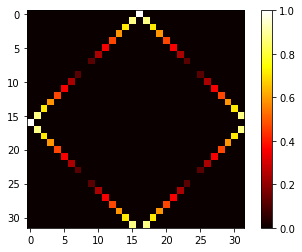

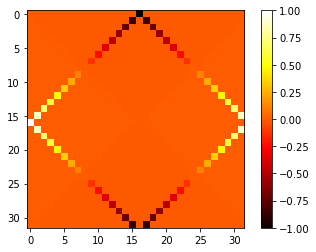

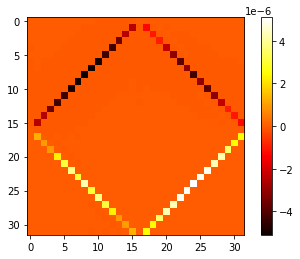

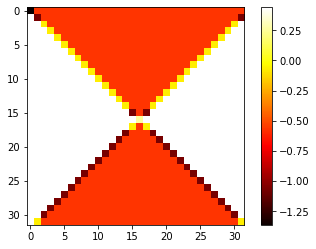

In [704]:
import matplotlib.pyplot as plt
maxelem = eig[:, 0][np.argmax(np.abs(eig[:, 0]))]
plt.imshow(np.abs(eig[:, 0] / maxelem).reshape((Ls, Ls)), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

import matplotlib.pyplot as plt
plt.imshow(np.real(eig[:, 0] / maxelem).reshape((Ls, Ls)), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

import matplotlib.pyplot as plt
plt.imshow(np.imag(eig[:, 0] / maxelem).reshape((Ls, Ls)), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()


import matplotlib.pyplot as plt
plt.imshow(np.angle(eig[:, 0]).reshape((Ls, Ls)) / np.pi - 0.5, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

In [705]:
print(np.trace(green[:, :, 0, 0]))
green[:, :, 0, 0]

(1.9531146240118928+0j)


array([[0.00024408+0.j, 0.00024645+0.j, 0.00025373+0.j, ...,
        0.00026653+0.j, 0.00025373+0.j, 0.00024645+0.j],
       [0.00024645+0.j, 0.00024886+0.j, 0.00025629+0.j, ...,
        0.00026936+0.j, 0.00025629+0.j, 0.00024886+0.j],
       [0.00025373+0.j, 0.00025629+0.j, 0.00026418+0.j, ...,
        0.00027809+0.j, 0.00026418+0.j, 0.00025629+0.j],
       ...,
       [0.00026653+0.j, 0.00026936+0.j, 0.00027809+0.j, ...,
        0.00029354+0.j, 0.00027809+0.j, 0.00026936+0.j],
       [0.00025373+0.j, 0.00025629+0.j, 0.00026418+0.j, ...,
        0.00027809+0.j, 0.00026418+0.j, 0.00025629+0.j],
       [0.00024645+0.j, 0.00024886+0.j, 0.00025629+0.j, ...,
        0.00026936+0.j, 0.00025629+0.j, 0.00024886+0.j]])

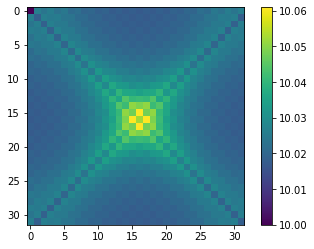

In [706]:
Gsingletreal = np.diag(fft.dot(np.diag(Gsinglet.reshape(-1))).dot(fft.conj().T)).reshape((32, 32))
import matplotlib.pyplot as plt
plt.imshow(np.real(Gsinglet).reshape((32, 32)))#, interpolation='nearest')
plt.colorbar()
plt.show()